In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from color_schema import *

print(method_names)

{'truecardinality': 'TrueCardinality', 'duckdb': 'DuckDB', 'panda': 'PANDA', 'lpbound': 'LPBound', 'safebound': 'SafeBound', 'dbx': 'DBX', 'factorjoin': 'FactorJoin', 'bayescard': 'BayesCard', 'deepdb': 'DeepDB', 'flat': 'Flat*', 'neurocard': 'NeuroCard*', 'postgres': 'Postgres', 'Postgres': 'Postgres', 'Postgres-Full': 'PostgresFull', 'postgresfull': 'PostgresFull', 'Postgres-Accurate': 'PostgresExactStats', 'Postgres-Full-Accurate': 'PostgresFullExactStats'}


In [3]:
methods = [
    "lpbound",
    "safebound",
    "dbx",
    "postgres",
    "factorjoin",
    "truecardinality",
]
benchmarks = ["joblight", "jobrange", "stats"]
query_id_map = {
    "jobrange": "JOBr",
    "joblight": "JOBl",
    "stats": "STATS"
}
runtime_dir = "../results/evaluation_time"

In [4]:
def construct_df():
    # construct a dataframe for all methods and all benchmarks
    df = pd.DataFrame() # benchmark, method, QueryID, Runtime
    for benchmark in benchmarks:
        for method in methods:
            try:
                file = f"{runtime_dir}/{benchmark}/{method}_evaluation_time.csv"
                df_method = pd.read_csv(file) # queryID, runtime
                df_method["benchmark"] = benchmark
                df_method["method"] = method
                df_method["ID"] = df_method["benchmark"] + "_" + df_method["QueryID"].astype(str)
                df = pd.concat([df, df_method])
            except:
                pass
    return df

overall_df = construct_df()

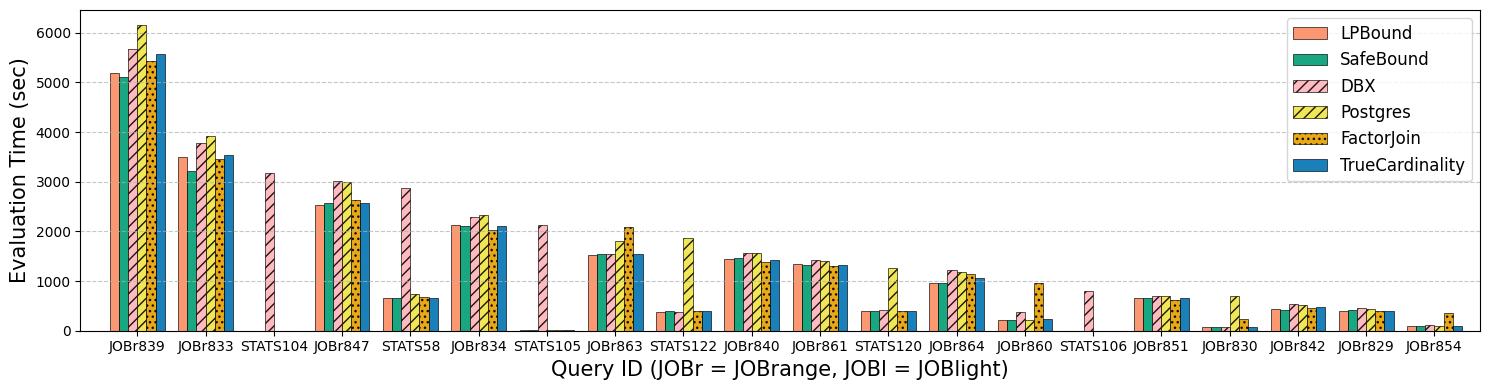

In [5]:
from matplotlib.ticker import LogFormatterSciNotation

def get_most_expensive_queries(df):
    # Get the 20 most expensive queries overall
    # use Runtime to sort the queries
    # get the IDs of the 20 most expensive queries
    df = df.sort_values(by='Runtime', ascending=False)
    most_expensive_query_ids = df['ID'].unique()[:20]
    # print(most_expensive_query_ids)

    filtered_df = df[df['ID'].isin(most_expensive_query_ids)]

    # order the rows by Runtime
    filtered_df = filtered_df.sort_values(by='Runtime', ascending=False)

    # # order the rows by Runtime of the truecardinality method
    # order_most_expensive_queries = filtered_df[filtered_df['method'] == 'truecardinality'].sort_values(by='Runtime', ascending=False)['ID']
    # filtered_df = filtered_df.set_index('ID').loc[order_most_expensive_queries].reset_index()

    return filtered_df
    

def draw_most_expensive_queries(df):
    df = get_most_expensive_queries(overall_df)
    # df = overall_df

    query_ids = df['ID'].unique()
    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 4))

    # Set the width of each bar group
    group_width = 0.8
    bar_width = group_width / len(methods)

    # Create the grouped bar chart
    for i, method in enumerate(methods):
        method_data = df[df['method'] == method]
        x = np.arange(len(query_ids))
        runtimes = [method_data[method_data['ID'] == qid]['Runtime'].mean() for qid in query_ids]
        
        # Determine the category of the method
        category = next((cat for cat, methods in categories.items() if method in methods), None)
        
        # Set the pattern for the bar
        pattern = category_patterns.get(category, '')
        
        bars = ax.bar(x + i*bar_width, runtimes, bar_width, label=method_names[method], 
                      color=ESTIMATOR_COLORS[method_names[method]], alpha=0.9, 
                      edgecolor='black', linewidth=0.5)
        
        # Add pattern to the bars
        if pattern:
            for bar in bars:
                bar.set_hatch(pattern)

    # Customize the plot
    ax.set_xlabel('Query ID (JOBr = JOBrange, JOBl = JOBlight)', fontsize=15)
    ax.set_ylabel('Evaluation Time (sec)', fontsize=15)

    # Set x-ticks to be centered for each group
    ax.set_xticks(x + group_width/2 - bar_width/2)


    query_id_labels = [f"{query_id_map[qid.split('_')[0]]}{qid.split('_')[1]}" for qid in query_ids]
    ax.set_xticklabels(query_id_labels, rotation=0)

    # Add legend: put it at the upper right corner
    ax.legend(loc='upper right', fontsize=12)

    # Add grid lines for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # reduce margin of the bars at the two ends
    plt.xlim(-0.5, len(query_ids))

    plt.tight_layout()

    # Draw the plot
    fig.canvas.draw()
    
    # Save the figure as a PDF
    output_filename = f"plots/most_expensive_queries.pdf"
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    
    plt.savefig(output_filename, format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Close the figure to free up memory
    plt.close(fig)

draw_most_expensive_queries(overall_df)


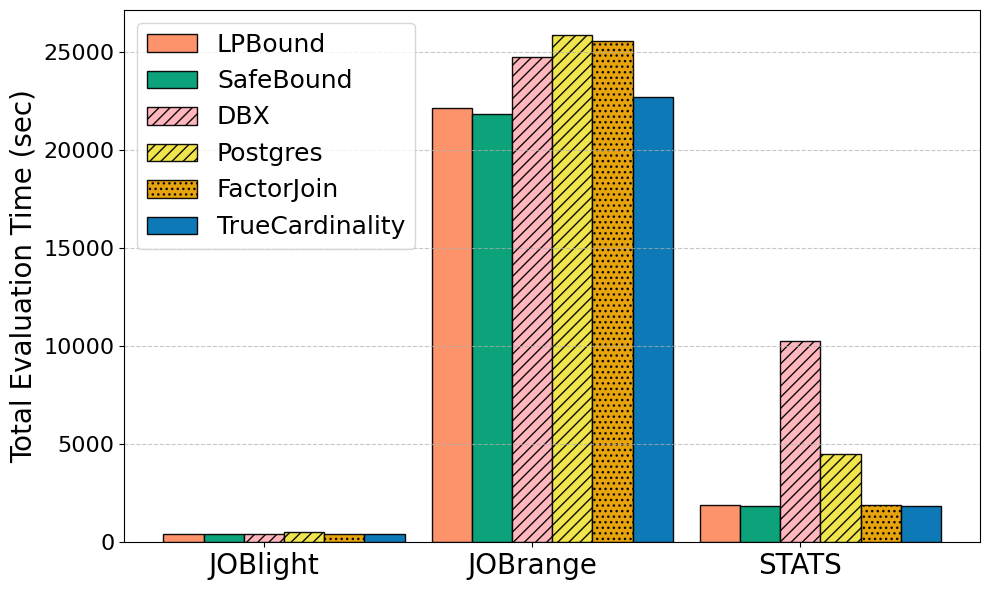

In [6]:
def draw_overall_bar_plot(df):
    # Group the data by benchmark and method, then sum the runtimes
    grouped_data = df.groupby(['benchmark', 'method'])['Runtime'].sum().unstack()

    # Reorder the columns (methods) and index (benchmarks)
    grouped_data = grouped_data.reindex(columns=methods, index=benchmarks)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the width of each bar and the positions of the bars
    bar_width = 0.15
    index = range(len(benchmarks))

    # Plot bars for each method
    for i, method in enumerate(methods):
        # Determine the category of the method
        category = next((cat for cat, methods in categories.items() if method in methods), None)
        
        # Set the pattern for the bar
        pattern = category_patterns.get(category, '')
        
        bars = ax.bar([x + i * bar_width for x in index], 
                      grouped_data[method], 
                      bar_width, 
                      label=method_names[method],
                      color=ESTIMATOR_COLORS[method_names[method]],
                      alpha=0.95,
                      edgecolor='black',
                      linewidth=1)
        
        # Add pattern to the bars
        if pattern:
            for bar in bars:
                bar.set_hatch(pattern)

    # Customize the plot
    this_benchmarks = [benchmark_names[benchmark.lower()] for benchmark in benchmarks]
    ax.set_ylabel('Total Evaluation Time (sec)', fontsize=20)
    ax.set_xticks([x + bar_width * 2 for x in index])
    ax.set_xticklabels(this_benchmarks, rotation=0, fontsize=20)

    # Add legend: put it at the upper left corner
    ax.legend(loc='upper left', fontsize=18)

    # make y-ticks larger
    ax.tick_params(axis='y', labelsize=16)

    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # 
    # # use log scale for y-axis
    # ax.set_yscale('log')
    # # Use LogFormatterSciNotation for y-axis labels
    # formatter = LogFormatterSciNotation(base=10, labelOnlyBase=False)
    # ax.yaxis.set_major_formatter(formatter)
    # # Optionally, set more tick locations
    # ax.yaxis.set_major_locator(ticker.LogLocator(numticks=10))
    # # Adjust y-axis limits if needed
    # ax.set_ylim(bottom=1, top=None)  # Set the bottom limit to 1 second 


    plt.tight_layout()
    # Draw the plot
    fig.canvas.draw()

    # Save the figure as a PDF
    output_filename = f"plots/overall_runtime.pdf"
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    plt.savefig(output_filename, format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Close the figure to free up memory
    plt.close(fig)

draw_overall_bar_plot(overall_df)

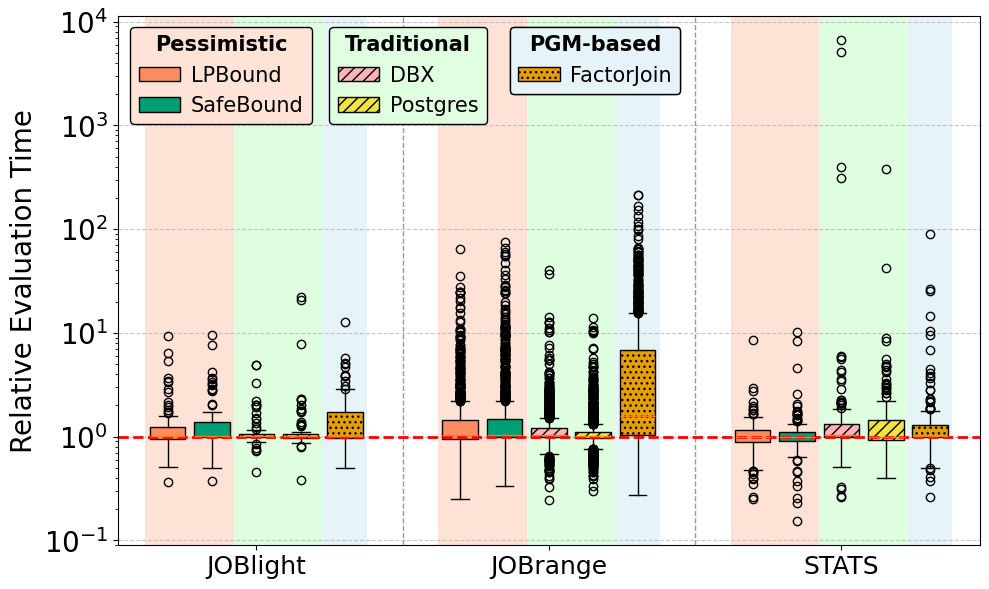

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Patch, Rectangle
import matplotlib.colors as mcolors
import colorsys

def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_relative_runtime_box_plot(df):
    # Calculate relative runtimes for each query
    df_relative = df.copy()
    for benchmark in benchmarks:
        for query_id in df_relative[df_relative['benchmark'] == benchmark]['QueryID'].unique():
            query_data = df_relative[(df_relative['benchmark'] == benchmark) & (df_relative['QueryID'] == query_id)]
            true_cardinality_runtime = query_data[query_data['method'] == 'truecardinality']['Runtime'].values[0]
            df_relative.loc[(df_relative['benchmark'] == benchmark) & (df_relative['QueryID'] == query_id), 'Relative Runtime'] = \
                df_relative.loc[(df_relative['benchmark'] == benchmark) & (df_relative['QueryID'] == query_id), 'Runtime'] / true_cardinality_runtime

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Exclude 'truecardinality' from the methods to plot
    plot_methods = [m for m in methods if m != 'truecardinality']

    # Calculate positions and widths
    num_benchmarks = len(benchmarks)
    total_width = 0.9 * num_benchmarks
    width_per_method = total_width / (len(plot_methods) * num_benchmarks)
    fixed_width = width_per_method * 0.8
    gap = 0.05  # Gap between benchmarks

    # Calculate positions for each benchmark
    positions = []
    benchmark_starts = [0]
    current_pos = 0
    for _ in benchmarks:
        benchmark_width = len(plot_methods) * width_per_method
        positions.append(current_pos + benchmark_width / 2)
        current_pos += benchmark_width + gap
        benchmark_starts.append(current_pos)

    # Draw category backgrounds and position boxes
    for i, benchmark in enumerate(benchmarks):
        benchmark_start = benchmark_starts[i]
        benchmark_end = benchmark_starts[i+1] - gap
        benchmark_center = (benchmark_start + benchmark_end) / 2
        benchmark_width = benchmark_end - benchmark_start
        
        present_categories = [cat for cat, cat_methods in categories.items() if any(m in plot_methods for m in cat_methods)]
        total_methods = sum(len([m for m in categories[cat] if m in plot_methods]) for cat in present_categories)
        
        category_start = benchmark_center - (total_methods * fixed_width) / 2
        for category in present_categories:
            category_methods = [m for m in categories[category] if m in plot_methods]
            category_width = len(category_methods) * fixed_width
            
            # Draw category background
            rect = patches.Rectangle((category_start, 0), category_width, 1, 
                                     fill=True, facecolor=category_colors[category], 
                                     alpha=0.3, transform=ax.get_xaxis_transform(), 
                                     zorder=0)
            ax.add_patch(rect)
            
            # Position boxes within the category
            for k, method in enumerate(category_methods):
                method_data = df_relative[(df_relative['benchmark'] == benchmark) & (df_relative['method'] == method)]['Relative Runtime']
                if not method_data.empty:
                    box_pos = category_start + (k + 0.5) * fixed_width
                    bp = ax.boxplot([method_data], 
                                    positions=[box_pos], 
                                    widths=fixed_width * 0.8,
                                    patch_artist=True)
                    
                    color = ESTIMATOR_COLORS[method_names[method]]
                    pattern = category_patterns[category]
                
                    for patch in bp['boxes']:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_hatch(pattern)
            
            category_start += category_width

    # Add vertical lines between benchmarks
    for end in benchmark_starts[1:-1]:
        ax.axvline(end - gap/2, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)

    # Customize the plot
    ax.set_ylabel('Relative Evaluation Time', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Set x-ticks and labels
    ax.set_xticks(positions)
    x_labels = [f"{benchmark_names[benchmark.lower()]}" for benchmark in benchmarks]
    ax.set_xticklabels(x_labels, fontsize=18)

    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a horizontal line at y=1 to represent the baseline (true cardinalities)
    ax.axhline(y=1, color='r', linestyle='--', linewidth=2)

    # Set y-axis to logarithmic scale
    ax.set_yscale('log')

    # Create separate legends for each category
    filtered_categories = []
    for category, category_methods in categories.items():
        present_methods = [method for method in category_methods if method in plot_methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        
        total_width = 0.65
        box_width = total_width / len(filtered_categories)
        start_x = 0.12

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            
            for method in category_methods:
                if method in plot_methods:
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            # Create a legend for this category
            legend = ax.legend(legend_elements, legend_labels,
                            title=category,
                            loc='upper center',
                            bbox_to_anchor=(start_x + i * box_width, 0.98),
                            bbox_transform=ax.transAxes,
                            fontsize=15,
                            title_fontsize=15,
                            frameon=True,
                            edgecolor='black',
                            borderaxespad=0,
                            handletextpad=0.5,
                            columnspacing=1.0)
            
            # Set the legend title to bold
            legend.get_title().set_fontweight('bold')
            
            # Set the background color of the legend
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)
            
            # Add the legend to the list of legends
            legends.append(legend)
        
        # Add all legends to the plot
        for legend in legends:
            ax.add_artist(legend)

    # Adjust x-axis limits to reduce margins
    ax.set_xlim(0, benchmark_starts[-1] - gap)

    ax.set_axisbelow(True)

    plt.tight_layout()
    
    # Save the figure as a PDF
    output_filename = f"plots/relative_runtime.pdf"
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    plt.savefig(output_filename, format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Close the figure to free up memory
    plt.close(fig)

# Call the function
draw_relative_runtime_box_plot(overall_df)
